In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
# From modules folder
from modules.models_execution import classificationModel, solve_opti_model
from modules.plots import plot_result, process_accuracy, process_opti_factors
from modules.active_learning import random_selection, uncertainty_selection, distribution_selection, duality_selection

# Classification Model

In [3]:
df = pd.read_csv('data/habitat-suitability.csv')

In [4]:
df

,Altitude,Distance_from_Human_Paths,Livestock_Density,Vegetation_Diversity_Index,Water_Source_Availability,Human_Disturbance_Index,Slope,Annual_Rainfall,Bamboo_Coverage,Mean_Annual_Temperature,Suitable
0,2023.988261,233.915650,3.340433,0.004449,1,1.047134,23.136856,566.418927,10.931381,11.216333,1
1,3291.571474,202.416726,2.696428,0.011408,0,1.168012,17.124186,284.616720,49.272585,2.867277,0
2,2810.386672,96.885777,4.996221,0.001876,1,1.120357,15.970847,514.922944,75.865653,4.973466,0
3,2517.048665,467.312224,3.367542,0.004580,0,0.826928,17.213960,401.346841,119.316952,6.729508,0
4,1543.241009,323.727725,2.785573,0.009529,1,1.285206,11.712508,697.497700,10.044292,12.016826,1
...,...,...,...,...,...,...,...,...,...,...,...
9995,3086.843174,1047.942515,2.833574,0.007758,0,0.755481,5.319288,278.967119,47.254330,3.012114,0
9996,3174.519437,23.972588,2.331570,0.013979,0,0.896459,17.397050,219.435015,98.759793,4.709172,0
9997,3282.757413,180.986239,2.879215,0.013206,1,0.644769,6.531635,292.940575,92.248487,2.835185,0
9998,2074.473583,292.882361,4.616194,0.001983,0,1.046871,20.329355,508.999587,18.240434,10.360199,1


### **Baseline Model** (with full information)

In [5]:
baseline_accuracy = []
for seed in range(1, 11):
    sample_accuracy, _, _ = classificationModel(df, seed=seed)
    baseline_accuracy.append(sample_accuracy)

In [6]:
baseline_accuracy = np.mean(baseline_accuracy)

### **Random Active Learning**

In [15]:
# Average across seeds to get a more robust result:
tot_accuracies = []

for seed in range(1, 11):
    accuracies = {}
    
    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    
    step = 50

    for size in range(50, 1000, step):
        ### TRAIN CLASSIFICATION MODEL
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)
        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]

        current_sample, not_labelled_df = random_selection(current_sample, not_labelled_df, step, seed)

    tot_accuracies.append(accuracies)

In [24]:
accuracies_df, stats_sample_df, stats_full_df = process_accuracy(tot_accuracies)

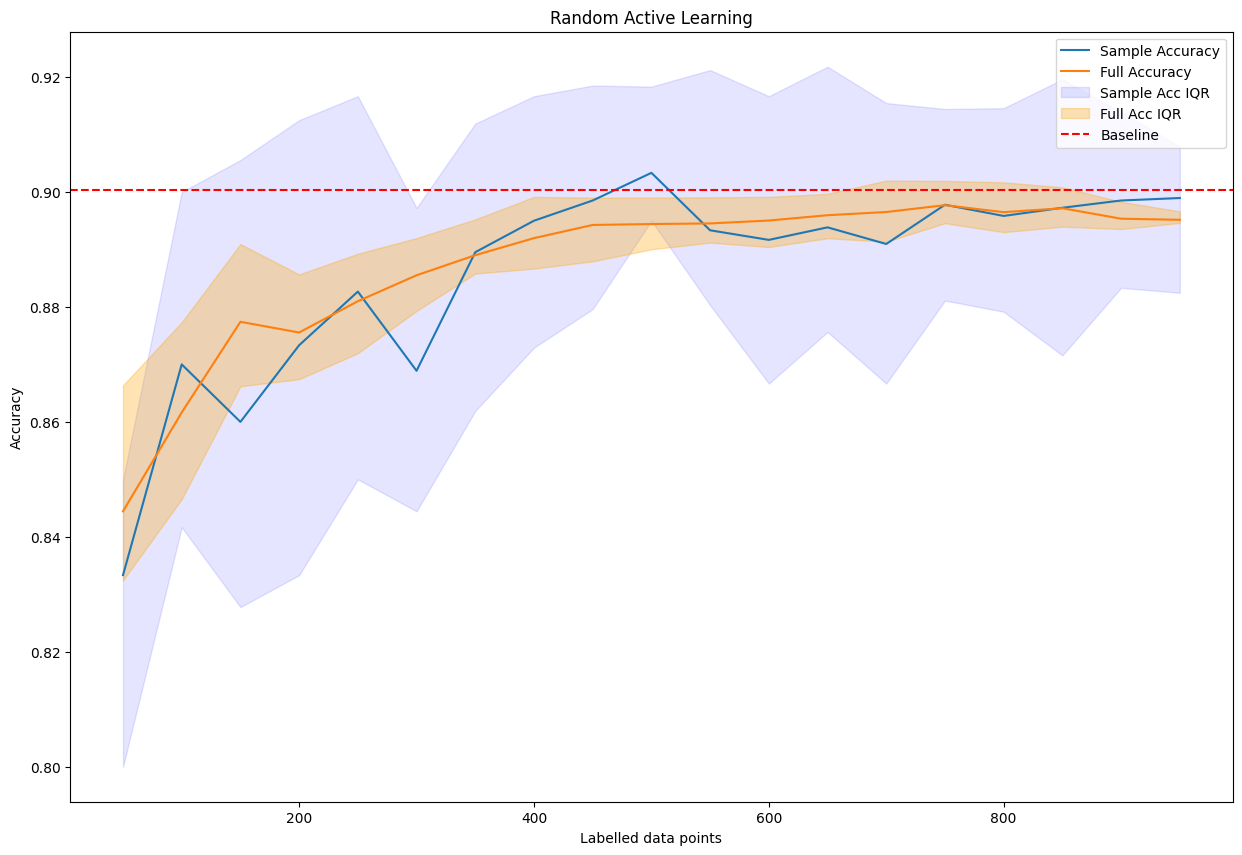

In [25]:
plot_result(accuracies_df, stats_sample_df, stats_full_df, baseline_accuracy, 'Random Active Learning', show_iqr_sample=True)

### **Uncertainty Based Active Learning**

In [5]:
tot_accuracies_u = []

for seed in range(1, 11):
    accuracies_u = {}
    
    non_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    
    step = 50

    for size in range(50, 1000, step):
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed=seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(non_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(non_labelled_df['Suitable'], full_y_pred)
        # Store accuracies
        accuracies_u[size] = [sample_acc, full_acc]
        # Update sample  -- Uncertainty based
        current_sample, non_labelled_df = uncertainty_selection(current_sample, non_labelled_df, step, model, full_X_train_scaled)

    tot_accuracies_u.append(accuracies_u)

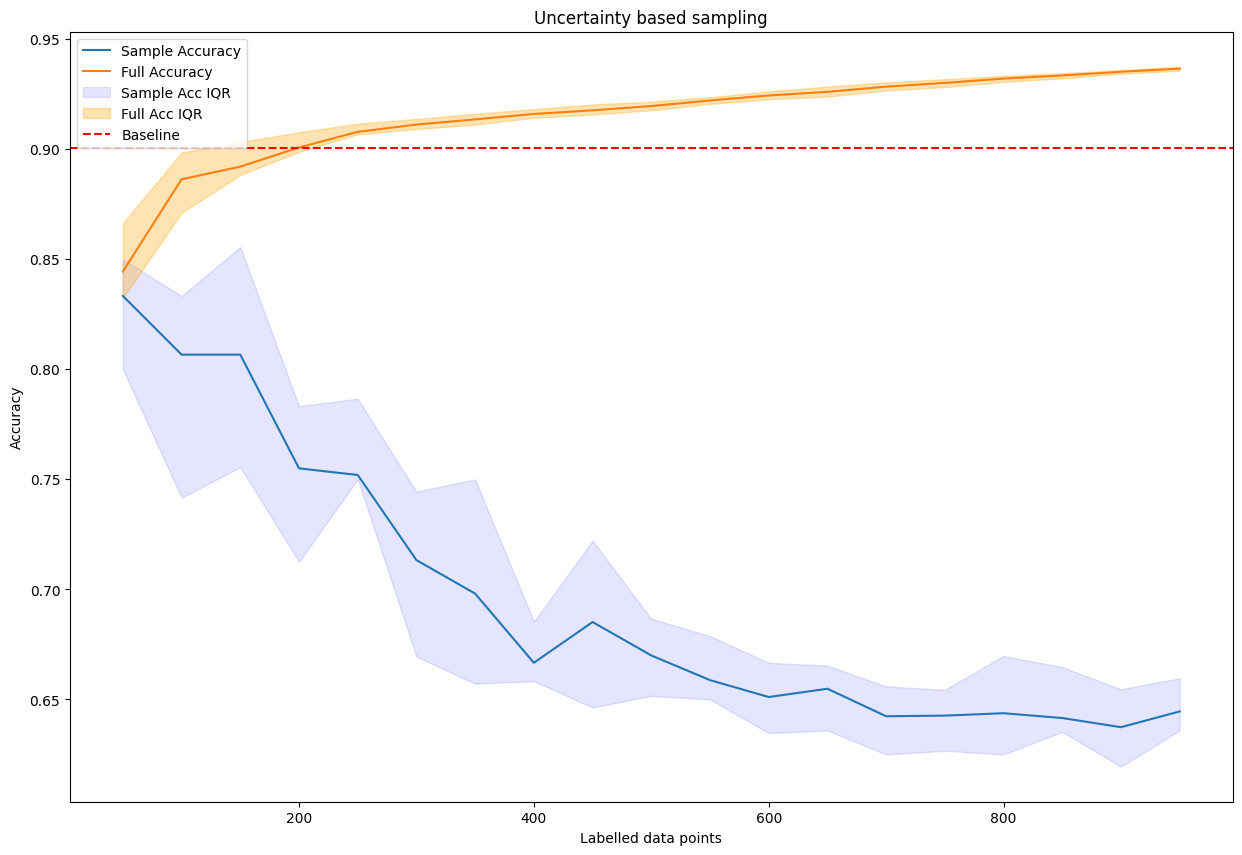

In [9]:
accuracies_u_df, stats_sample_u_df, stats_full_u_df = process_accuracy(tot_accuracies_u)

plot_result(accuracies_u_df, stats_sample_u_df, stats_full_u_df, baseline_accuracy, 'Uncertainty based sampling', show_iqr_sample=True)

### **Feature Distribution Based Active Learning**

In [37]:
tot_accuracies_f = []

for seed in range(1, 11):

    # Initialize sample (stratified)
    non_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    
    step = 50
    accuracies_f = {}

    for size in range(50, 1000, step):
        sample_acc, model, scaler = classificationModel(current_sample, seed=seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(non_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(non_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies_f[size] = [sample_acc, full_acc]

        current_sample, non_labelled_df = distribution_selection(current_sample, non_labelled_df, step)
    
    tot_accuracies_f.append(accuracies_f)

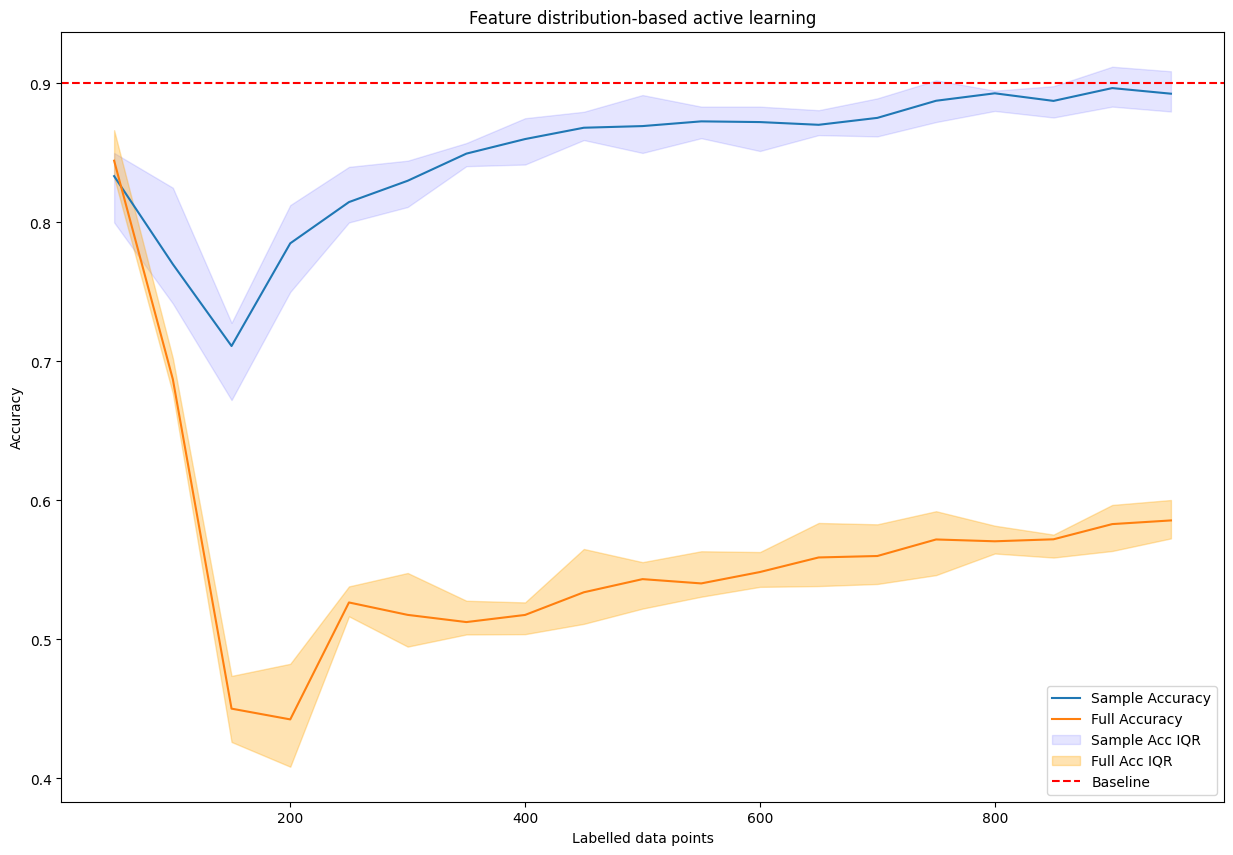

In [40]:
accuracies_f_df, stats_sample_f_df, stats_full_f_df = process_accuracy(tot_accuracies_f)

plot_result(accuracies_f_df, stats_sample_f_df, stats_full_f_df, baseline_accuracy, 'Feature distribution-based active learning', show_iqr_sample=True)

### **Feature Distribution and Uncertainty Based Active Learning**

In [7]:
from sklearn.metrics import accuracy_score
from scipy.spatial.distance import cdist

tot_accuracies_uf = []

for seed in range(1, 11):

    # Initialize sample (stratified)
    non_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    
    step = 50
    accuracies_uf = {}

    for size in range(50, 1000, step):
        sample_acc, model, scaler = classificationModel(current_sample, seed=seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(non_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(non_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies_uf[size] = [sample_acc, full_acc]

        # Uncertainty based selection
        current_sample, non_labelled_df = uncertainty_selection(current_sample, non_labelled_df, step//2, model, full_X_train_scaled)
        # Dissimilarity based selection
        current_sample, non_labelled_df = distribution_selection(current_sample, non_labelled_df, step//2)

    tot_accuracies_uf.append(accuracies_uf)

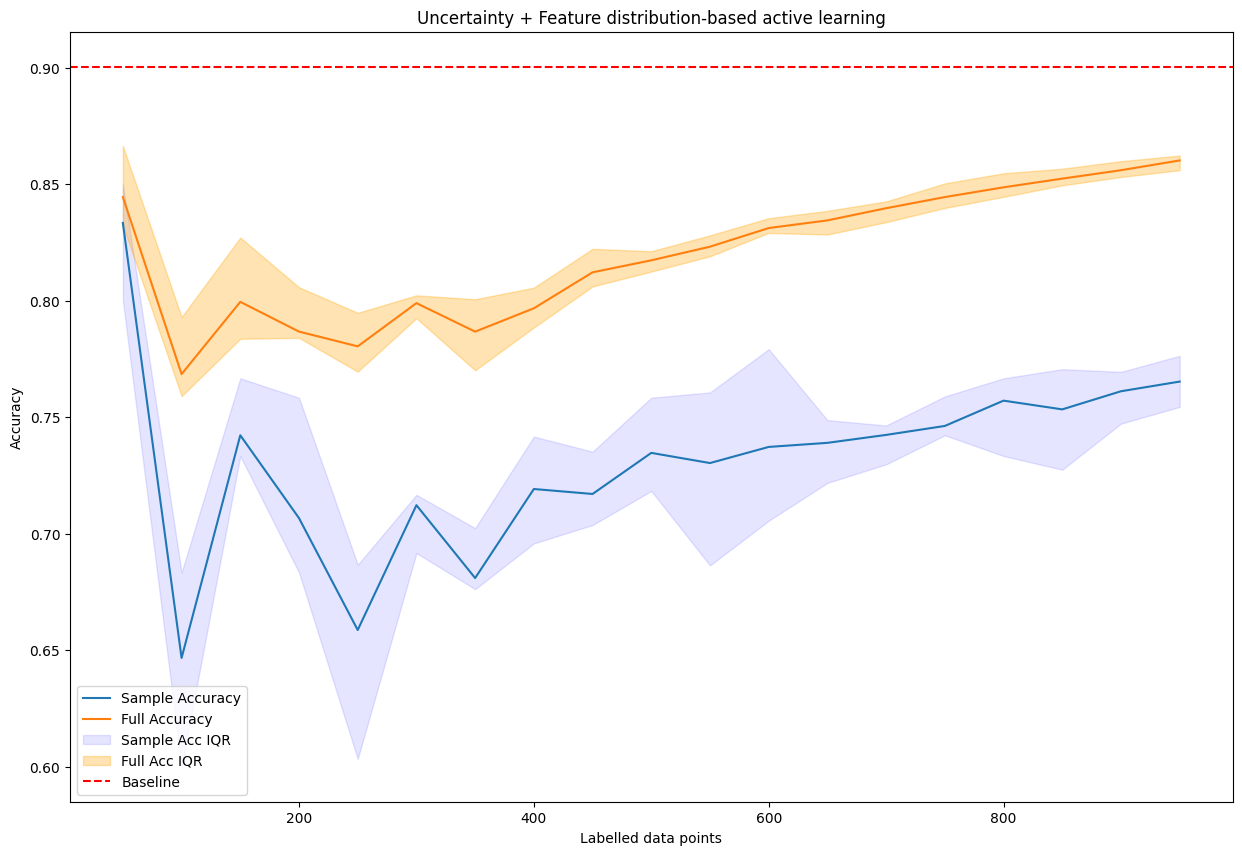

In [8]:
accuracies_uf_df, stats_sample_uf_df, stats_full_uf_df = process_accuracy(tot_accuracies_uf)

plot_result(accuracies_uf_df, stats_sample_uf_df, stats_full_uf_df, baseline_accuracy, 'Uncertainty + Feature distribution-based active learning', show_iqr_sample=True)

## **Summary of Baseline**

NameError: name 'accuracies_u_df' is not defined

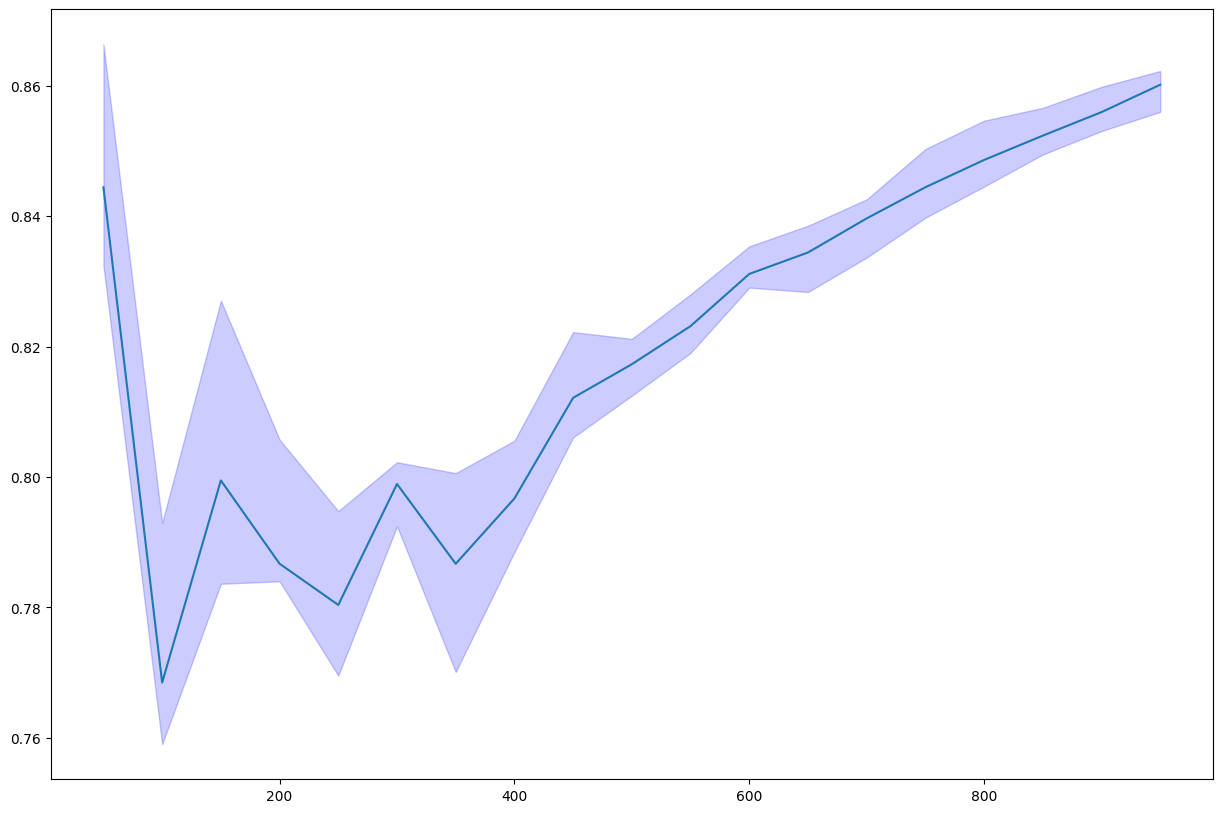

In [9]:
# Plotting
plt.figure(figsize=(15,10))

# Plot average accuracies
plt.plot(accuracies_uf_df.reset_index()['index'], accuracies_uf_df['Full Accuracy'], label='Full Accuracy Uncertainty + Feature')
plt.fill_between(accuracies_uf_df.reset_index()['index'], stats_full_uf_df['25%'], stats_full_uf_df['75%'], color='blue', alpha=0.2)

plt.plot(accuracies_u_df.reset_index()['index'], accuracies_u_df['Full Accuracy'], label='Full Accuracy Uncertainty')
plt.fill_between(accuracies_u_df.reset_index()['index'], stats_full_u_df['25%'], stats_full_u_df['75%'], color='orange', alpha=0.3)

plt.plot(accuracies_f_df.reset_index()['index'], accuracies_f_df['Full Accuracy'], label='Full Accuracy Feature')
plt.fill_between(accuracies_f_df.reset_index()['index'], stats_full_f_df['25%'], stats_full_f_df['75%'], color='green', alpha=0.2)

plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Full Accuracy'], label='Full Accuracy Random')
plt.fill_between(accuracies_df.reset_index()['index'], stats_full_df['25%'], stats_full_df['75%'], color='red', alpha=0.2)

# Baseline accuracy and other plot settings
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
plt.legend()
plt.title('Summary of traditional AL approaches - Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')
plt.show()

# **Optimization Model**

In this section, we define the optimization model and run it with full information. This result will be used as benchmark in the evaluation of active learning strategies. Furthermore, we test the optimization-aware active learning logic in terms of accuracy.

In [7]:
from gurobipy import Model, GRB

### READ DATA
# Reading CSV files
supply = pd.read_csv("data/opti-origin_supply.csv")["Value"].to_numpy()
tr_capacity = pd.read_csv("data/opti-transshipment_capacity.csv")["Value"].to_numpy()
des_capacity = pd.read_csv("data/opti-destination_capacity.csv")["Value"].to_numpy()

cost_1 = pd.read_csv("data/opti-origin_to_transshipment_cost.csv")
cost_1 = cost_1.pivot(index='Origin', columns='Hub', values='Value').fillna(0).to_numpy()

cost_2 = pd.read_csv("data/opti-transshipment_to_destination_cost.csv")
cost_2 = cost_2.pivot(index='Hub', columns='Destination', values='Value').fillna(0).to_numpy()

In [8]:
## To be used for I-SET active learning
cost_2 = pd.read_csv("data/opti-transshipment_to_destination_cost.csv")
cost_2 = cost_2.pivot(index='Hub', columns='Destination', values='Value').fillna(0).to_numpy()
cost_2_df = pd.DataFrame(cost_2)
cost_2_df = cost_2_df.reset_index().rename(columns={'index':'j'})
cost_2_df = cost_2_df.melt(id_vars=['j'], var_name='k', value_name='cost')

cost_2_df.head()

,j,k,cost
0,0,0,46
1,1,0,21
2,2,0,3
3,3,0,37
4,4,0,57


### **Optimization model baseline (full information)**

In [9]:
z = df['Suitable'].to_numpy()

opt_objective, df_X, df_Y, dual_df = solve_opti_model(z, supply, tr_capacity, des_capacity, cost_1, cost_2, df)

Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-18


In [10]:
full_info_objective = opt_objective

print(f"Optimal Objective Value: {opt_objective}")

Optimal Objective Value: 14933590.0


In [11]:
dual_df

,Constraint,Slack,Dual Value,Suitable,Capacity
0,Link_0,0.0,-11.0,1,71
1,Link_1,0.0,-12.0,0,74
2,Link_2,0.0,0.0,0,56
3,Link_3,0.0,-4.0,0,80
4,Link_4,0.0,-9.0,1,55
...,...,...,...,...,...
9995,Link_9995,0.0,0.0,0,59
9996,Link_9996,0.0,0.0,0,96
9997,Link_9997,0.0,-6.0,0,92
9998,Link_9998,0.0,-10.0,1,77


In [12]:
df_Y_optimal = df_Y
df_Y_optimal

,Value,j,k
0,0.0,0,0
1,0.0,0,1
2,0.0,0,2
3,0.0,0,3
4,0.0,0,4
...,...,...,...
79995,0.0,7,9995
79996,0.0,7,9996
79997,0.0,7,9997
79998,0.0,7,9998


In [13]:
dual_df[(dual_df['Suitable']==0) & (dual_df['Dual Value']!=0)].sort_values(by='Dual Value', ascending=True)

,Constraint,Slack,Dual Value,Suitable,Capacity
1244,Link_1244,0.0,-13.0,0,88
1447,Link_1447,0.0,-13.0,0,67
7475,Link_7475,0.0,-13.0,0,67
3096,Link_3096,0.0,-13.0,0,55
3106,Link_3106,0.0,-13.0,0,72
...,...,...,...,...,...
7719,Link_7719,0.0,-1.0,0,76
554,Link_554,0.0,-1.0,0,51
3454,Link_3454,0.0,-1.0,0,99
7671,Link_7671,0.0,-1.0,0,66


### **Optimization-based active learning** - O-set and I-set

In [23]:
# Average across seeds to get a more robust result:
tot_accuracies_o_and_i_set = []

for seed in range(1, 5):

    accuracies = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])

    step = 50

    for size in range(50, 1000, step):
        ### TRAIN CLASSIFICATION MODEL
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)  
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)
        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]

        ### COMPUTE FULL PREDICTION / Z HAT VECTOR
        # Compute Z hat vector
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']
        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])
        
        ### SOLVE OPTIMIZATION MODEL
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy(), supply, tr_capacity, des_capacity, cost_1, cost_2, df)

        ### UPDATE SAMPLE
        if opt_objective > 0: # feasible
            current_sample, not_labelled_df = duality_selection(dual_df, df_Y, z_hat_df, current_sample, not_labelled_df, step, cost_2_df)
            
    tot_accuracies_o_and_i_set.append(accuracies)

KeyboardInterrupt: 

In [ ]:
accuracies_dual_df, stats_sample_dual_df, stats_full_dual_df = process_accuracy(tot_accuracies_o_and_i_set)
plot_result(accuracies_dual_df, stats_sample_dual_df, stats_full_dual_df, baseline_accuracy, 'Duality-based active learning', show_iqr_sample=True)

### **Optimization-based active learning** - Aggregate Strategies

In [ ]:
# Average across seeds to get a more robust result:
tot_accuracies_duality_feature_uncertainty = []

for seed in range(1, 5):

    accuracies = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])

    step = 50

    for size in range(50, 1000, step):
        
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)

        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)  
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)

        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]

        # Compute Z hat vector
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']

        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])
        
        # Solve optimization model
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy())

        # Indexes of highest dual variables
        if opt_objective > 0: # feasible
            ### O SET - DUAL VARIABLES
            dual_df = pd.merge(dual_df, z_hat_df[['z_hat_adjusted']], left_index=True, right_index=True, how='left')
            O_set = dual_df[(dual_df['z_hat_adjusted']==0) & (dual_df['Dual Value']!=0)].sort_values(by='Dual Value', ascending=True)
            O_set_without_labelled = O_set[~O_set.index.isin(current_sample.index)]

            indexes = O_set_without_labelled.head(int(step/4)).index
            new_labels = not_labelled_df.loc[indexes]
            
            not_labelled_df = not_labelled_df.drop(new_labels.index)

            current_sample = pd.concat([current_sample, new_labels])

            ### I SET - COST
            merged_cost = pd.merge(df_Y, cost_2_df, on=['j', 'k'], how='left')
            I_set = merged_cost.groupby('k')[['Value']].sum().sort_values(by='Value', ascending=False).reset_index()

            I_set_without_labelled = I_set[~I_set['k'].isin(current_sample.index)]

            indexes = I_set_without_labelled.head(int(step/4))['k'].tolist()
            new_labels = not_labelled_df.loc[indexes]
            
            not_labelled_df = not_labelled_df.drop(new_labels.index)

            current_sample = pd.concat([current_sample, new_labels])
            
            # Uncertainty based selection
            predicted_proba = model.predict_proba(full_X_train_scaled)
            predicted_proba_df = pd.DataFrame(predicted_proba[:,1], index=non_labelled_df.index)
            predicted_proba_df['uncertainty_diff'] = (0.5 - predicted_proba_df[0]).abs()
            top_50_uncertain_points = predicted_proba_df.nsmallest(step//4, 'uncertainty_diff')
            to_be_labelled_uncertainty = non_labelled_df.loc[top_50_uncertain_points.index]

            current_sample = pd.concat([current_sample, to_be_labelled_uncertainty])
            non_labelled_df = non_labelled_df.drop(top_50_uncertain_points.index)
        
            # Dissimilarity based selection
            distances = cdist(non_labelled_df, current_sample, metric='euclidean')
            mean_distances = distances.mean(axis=1)
            dissimilarity_df = pd.DataFrame(mean_distances, index=non_labelled_df.index, columns=['dissimilarity'])
            dissimilar_points = dissimilarity_df.nlargest(step//4, 'dissimilarity')
            to_be_labelled_dissimilarity = non_labelled_df.loc[dissimilar_points.index]

            current_sample = pd.concat([current_sample, to_be_labelled_dissimilarity])
            non_labelled_df = non_labelled_df.drop(dissimilar_points.index)

#each strategy identifies 1/4 of the total batch to label.
            
    tot_accuracies_duality_feature_uncertainty.append(accuracies)

In [ ]:
list_of_dicts = tot_accuracies_duality_feature_uncertainty

sums = {key: (0, 0) for key in list_of_dicts[0].keys()}
# Initialize a dictionary to hold the count of entries for each key
counts = {key: 0 for key in list_of_dicts[0].keys()}

# Iterate over each dictionary and then each key to accumulate sums and counts
for d in list_of_dicts:
    for key, value_pair in d.items():
        # Sum the values for each key separately
        sums[key] = (sums[key][0] + value_pair[0], sums[key][1] + value_pair[1])
        # Increment the count for each key
        counts[key] += 1

# Calculate the average for each key
averages = {key: ((sums[key][0] / counts[key]), (sums[key][1] / counts[key])) for key in sums.keys()}

accuracies_df = pd.DataFrame(averages).T
accuracies_df.columns = ['Sample Accuracy', 'Full Accuracy']
all_accuracies_df = pd.DataFrame.from_records(list_of_dicts)

In [ ]:
def compute_stats(df, key, element_index=0):
    max_vals = df[key].apply(lambda x: x[element_index]).max()
    min_vals = df[key].apply(lambda x: x[element_index]).min()
    q25_vals = df[key].apply(lambda x: x[element_index]).quantile(0.25)
    q75_vals = df[key].apply(lambda x: x[element_index]).quantile(0.75)
    return max_vals, min_vals, q25_vals, q75_vals

# Compute stats for sample and full accuracy
stats_sample = {size: compute_stats(all_accuracies_df, size, element_index=0) for size in all_accuracies_df.columns}
stats_full = {size: compute_stats(all_accuracies_df, size, element_index=1) for size in all_accuracies_df.columns}

# Convert these stats into DataFrames
stats_sample_df = pd.DataFrame(stats_sample, index=['Max', 'Min', '25%', '75%']).T
stats_full_df = pd.DataFrame(stats_full, index=['Max', 'Min', '25%', '75%']).T
# Plotting
plt.figure(figsize=(15,10))

# Plot average accuracies
plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Sample Accuracy'], label='Sample Accuracy')
plt.plot(accuracies_df.reset_index()['index'], accuracies_df['Full Accuracy'], label='Full Accuracy')

# Optional: Plot IQR
# plt.fill_between(accuracies_df.reset_index()['index'], stats_sample_df['25%'], stats_sample_df['75%'], color='blue', alpha=0.3, label='Sample Acc IQR')
plt.fill_between(accuracies_df.reset_index()['index'], stats_full_df['25%'], stats_full_df['75%'], color='orange', alpha=0.3, label='Full Acc IQR')

# Baseline accuracy and other plot settings
plt.axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
plt.legend()
plt.title('Accuracy as a function of size')
plt.xlabel('Labelled data points')
plt.ylabel('Accuracy')
plt.show()

## **Evaluation of Optmization solution**

In this section we run the active learning logic while also measuring the impact on the optimization model. We consider the KPIs "Layout Factor" and "Objective Factor". Both are a measure of "distance" between the optimization model solution at iteration i, and the optimization model solution with full information. 

We consider:
- Random  (DONE)
- Uncertainty-based (DONE)
- Distribution-based (DONE)
- Optimization-Aware without initial batch selection (DONE)
- Optimization-Aware with initial batch selection
- (Uncertainty-based) + (Optimization-Aware) 
- (Distribution-based) + (Optimization-Aware)
- (Uncertainty-based) + (Distribution-based) + (Optimization-Aware)

### **Random Active Learning**

In [23]:
# Average across seeds to get a more robust result:
tot_accuracies = []
tot_objective_factor = []
tot_layout_factor = []

for seed in range(1, 6):
    print(f"Seed: {seed}")
    accuracies = {}
    losses = {}
    objective_factors = {}
    layout_factors = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    step = 50

    for size in range(50, 1000, step):
        ### RUN CLASSIFICATION MODEL        
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)
        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]
    
        ### COMPUTE FULL PREDICTION / Z HAT VECTOR
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']
        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])  # Adjust by setting the known labels

        ### RUN OPT MODEL
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy(), supply, tr_capacity, des_capacity, cost_1, cost_2, df)

        ### STORE OPTI KPIs 
        if opt_objective > 0: # feasible
            # Compute objective factor
            objective_factor = np.abs(1 - full_info_objective / opt_objective)
            # Compute layout factor
            comparison = pd.merge(df_Y_optimal, df_Y, on =['j','k'], how='inner')
            comparison['Difference'] = np.abs(comparison['Value_x'] - comparison['Value_y']) / 2
            layout_factor = comparison['Difference'].sum() / supply.sum()

            objective_factors[size] = objective_factor
            layout_factors[size] = layout_factor

        ### UPDATE SAMPLE
        current_sample, not_labelled_df = random_selection(current_sample, not_labelled_df, step, seed)
            
    tot_accuracies.append(accuracies)
    tot_objective_factor.append(objective_factors)
    tot_layout_factor.append(layout_factors)

Seed: 1
Seed: 2
Seed: 3
Seed: 4
Seed: 5


#### Accuracies Results

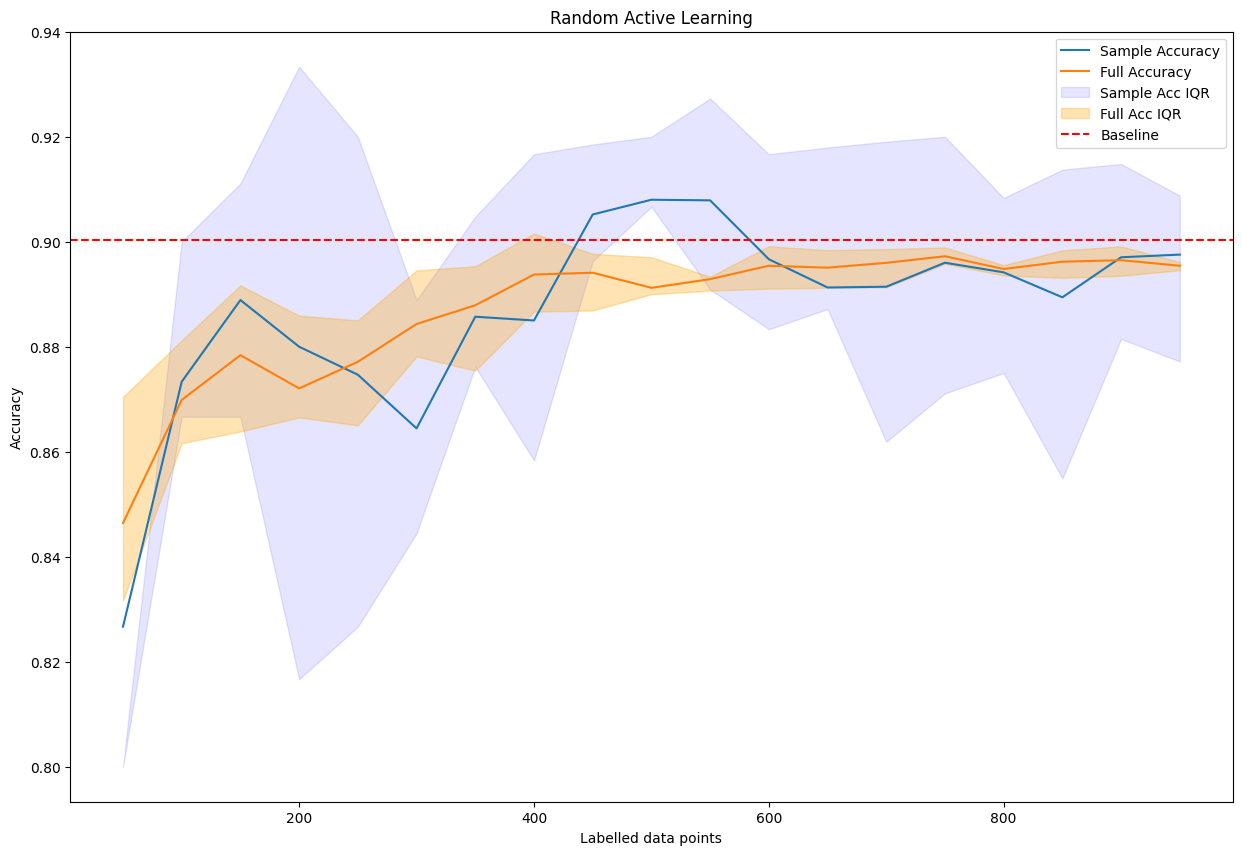

In [67]:
accuracies_df_random, stats_sample_df_random, stats_full_df_random = process_accuracy(tot_accuracies)
plot_result(accuracies_df_random, stats_sample_df_random, stats_full_df_random, baseline_accuracy, 'Random Active Learning', show_iqr_sample=True)

#### Optimization Results

In [25]:
layout_factor_random, objective_factor_random = process_opti_factors(tot_layout_factor, tot_objective_factor)

**Layout Factor**

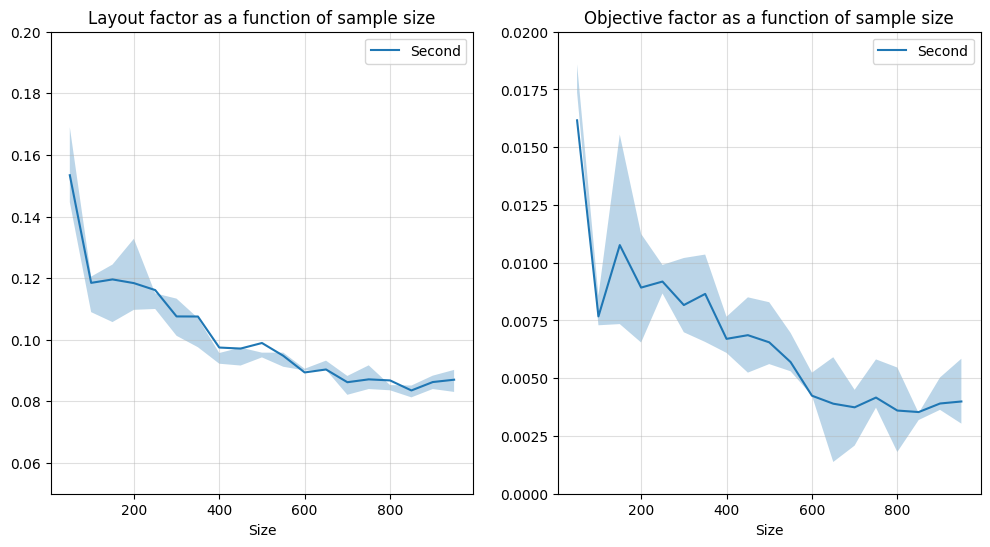

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

layout_factor_random.plot(x='Size', y='average', ax=ax[0], label='Second')
ax[0].fill_between(layout_factor_random['Size'], layout_factor_random['first_qnt'], layout_factor_random['third_qnt'], alpha=0.3)
ax[0].set_ylim([0.05,0.2])
ax[0].set_title('Layout factor as a function of sample size')
ax[0].grid(True, alpha=0.4)

objective_factor_random.plot(x='Size', y='average', ax=ax[1], label='Second')
ax[1].fill_between(objective_factor_random['Size'], objective_factor_random['first_qnt'], objective_factor_random['third_qnt'], alpha=0.3)
ax[1].set_ylim([0,0.02])
ax[1].set_title('Objective factor as a function of sample size')
ax[1].grid(True, alpha=0.4)

plt.legend()
plt.show()

### **Duality AL**

In [15]:
# Average across seeds to get a more robust result:
tot_accuracies_duality = []
tot_objective_factor_duality = []
tot_layout_factor_duality = []

for seed in range(1, 6):
    print(f"{seed}")
        
    accuracies = {}
    objective_factors = {}
    layout_factors = {}

    # Initialize sample (stratified)
    not_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])

    step = 50

    for size in range(50, 1000, step):
        ### TRAIN CLASSIFICATION MODEL
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(not_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)  
        full_acc = accuracy_score(not_labelled_df['Suitable'], full_y_pred)
        # Store accuracies
        accuracies[size] = [sample_acc, full_acc]

        ### COMPUTE FULL PREDICTION / Z HAT VECTOR
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']
        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])
        
        ### SOLVE OPTIMIZATION MODEL
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy(), supply, tr_capacity, des_capacity, cost_1, cost_2, df)

        ### STORE OPTI KPIs
        if opt_objective > 0: # feasible
            # Compute objective factor
            objective_factor = np.abs(1 - full_info_objective / opt_objective)
            # Compute layout factor
            comparison = pd.merge(df_Y_optimal, df_Y, on =['j','k'], how='inner')
            comparison['Difference'] = np.abs(comparison['Value_x'] - comparison['Value_y']) / 2
            layout_factor = comparison['Difference'].sum() / supply.sum()
            
            objective_factors[size] = objective_factor
            layout_factors[size] = layout_factor

        ### UPDATE SAMPLE
        current_sample, not_labelled_df = duality_selection(dual_df, df_Y, z_hat_df, current_sample, not_labelled_df, step, cost_2_df)
            
    tot_accuracies_duality.append(accuracies)
    tot_objective_factor_duality.append(objective_factors)
    tot_layout_factor_duality.append(layout_factors)


1
2
3
4
5


#### Accuracies Results

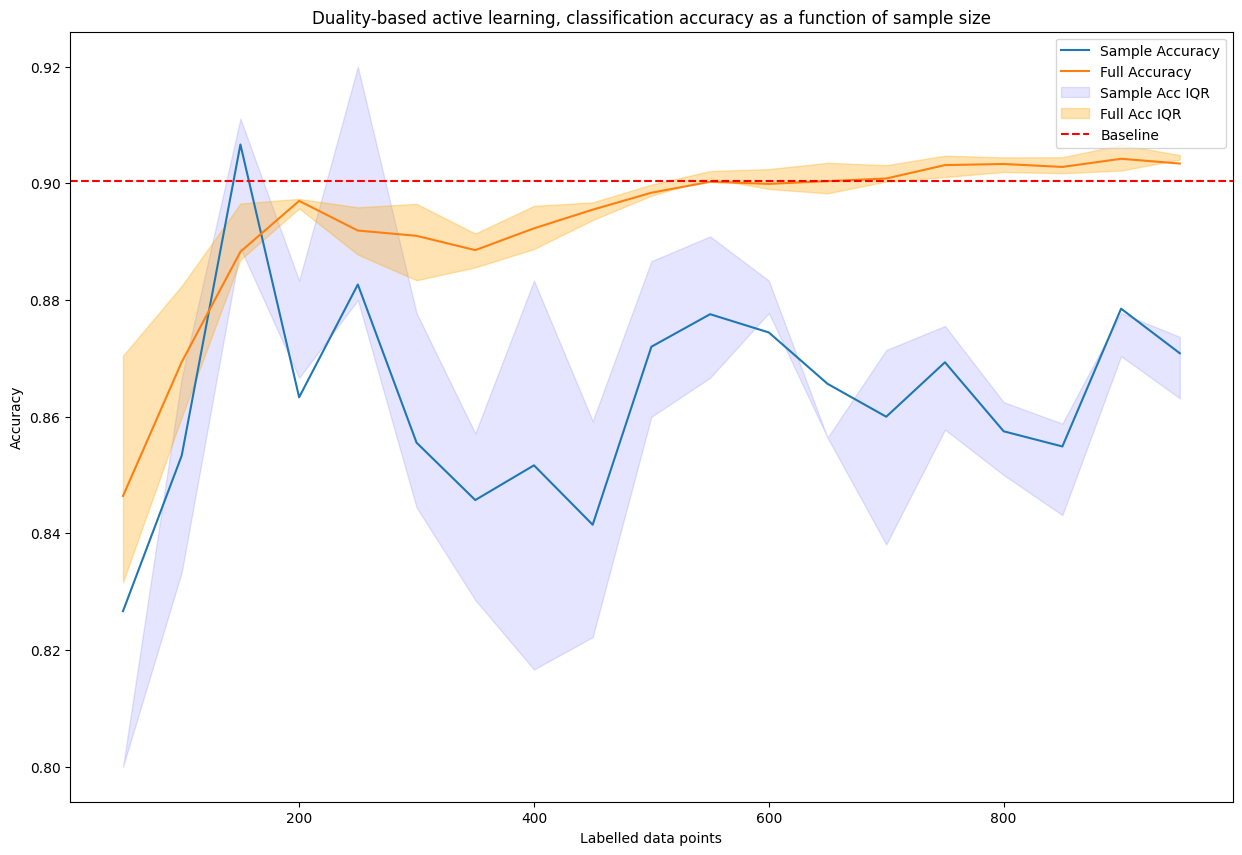

In [61]:
accuracies_df_duality, stats_sample_df_duality, stats_full_df_duality = process_accuracy(tot_accuracies_duality)
plot_result(accuracies_df_duality, stats_sample_df_duality, stats_full_df_duality, baseline_accuracy, 'Duality-based active learning, classification accuracy as a function of sample size', show_iqr_sample=True)

#### Optimization Results

In [18]:
layout_factor_duality, objective_factor_duality = process_opti_factors(tot_layout_factor_duality, tot_objective_factor_duality)

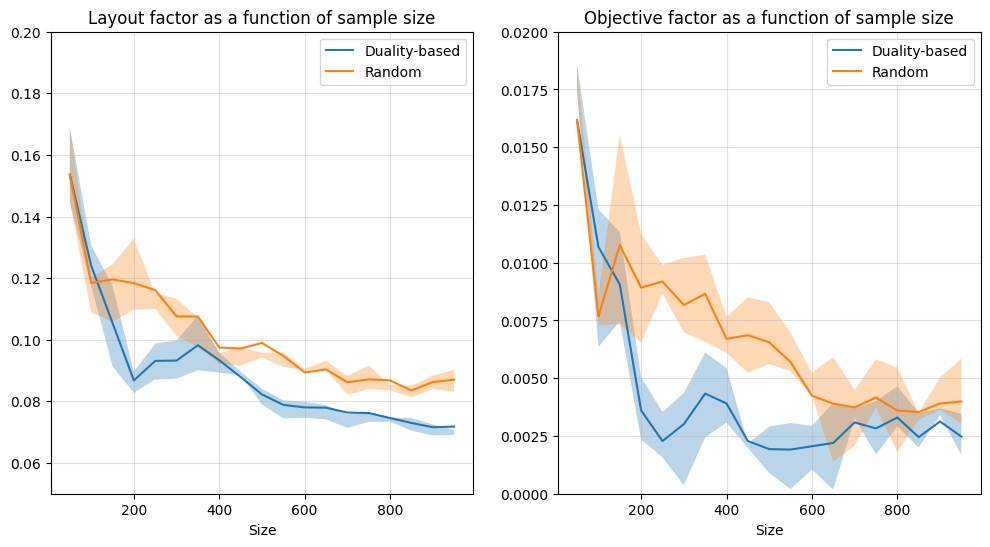

In [29]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

layout_factor_duality.plot(x='Size', y='average', ax=ax[0], label='Duality-based')
ax[0].fill_between(layout_factor_duality['Size'], layout_factor_duality['first_qnt'], layout_factor_duality['third_qnt'], alpha=0.3)
layout_factor_random.plot(x='Size', y='average', ax=ax[0], label='Random')
ax[0].fill_between(layout_factor_random['Size'], layout_factor_random['first_qnt'], layout_factor_random['third_qnt'], alpha=0.3)
ax[0].set_ylim([0.05,0.2])
ax[0].set_title('Layout factor as a function of sample size')
ax[0].grid(True, alpha=0.4)

objective_factor_duality.plot(x='Size', y='average', ax=ax[1], label='Duality-based')
ax[1].fill_between(objective_factor_duality['Size'], objective_factor_duality['first_qnt'], objective_factor_duality['third_qnt'], alpha=0.3)
objective_factor_random.plot(x='Size', y='average', ax=ax[1], label='Random')
ax[1].fill_between(objective_factor_random['Size'], objective_factor_random['first_qnt'], objective_factor_random['third_qnt'], alpha=0.3)
ax[1].set_ylim([0,0.02])
ax[1].set_title('Objective factor as a function of sample size')
ax[1].grid(True, alpha=0.4)

plt.legend()
plt.show()

### **Uncertainty based**

In [36]:
tot_accuracies_uncertainty = []
tot_objective_factor_uncertainty = []
tot_layout_factor_uncertainty = []

for seed in range(1, 6):
    print(f"{seed}")
    accuracies_u = {}
    objective_factors = {}
    layout_factors = {}

    non_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    step = 50
    
    for size in range(50, 1000, step):
        ### TRAIN CLASSIFICATION MODEL
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed=seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(non_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(non_labelled_df['Suitable'], full_y_pred)
        # Store accuracies
        accuracies_u[size] = [sample_acc, full_acc]

        ### COMPUTE FULL PREDICTION / Z HAT VECTOR
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']
        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])
        
        ### RUN OPTI MODEL
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy(), supply, tr_capacity, des_capacity, cost_1, cost_2, df)

        if opt_objective > 0: # feasible
            # Compute objective factor
            objective_factor = np.abs(1 - full_info_objective / opt_objective)
            # Compute layout factor
            comparison = pd.merge(df_Y_optimal, df_Y, on =['j','k'], how='inner')
            comparison['Difference'] = np.abs(comparison['Value_x'] - comparison['Value_y']) / 2
            layout_factor = comparison['Difference'].sum() / supply.sum()
            
            objective_factors[size] = objective_factor
            layout_factors[size] = layout_factor

        ### UPDATE SAMPLE
        # Uncertainty based
        current_sample, non_labelled_df = uncertainty_selection(current_sample, non_labelled_df, step, model, full_X_train_scaled)
            
    tot_accuracies_uncertainty.append(accuracies_u)
    tot_objective_factor_uncertainty.append(objective_factors)
    tot_layout_factor_uncertainty.append(layout_factors)

1
2
3
4
5


**Accuracy**

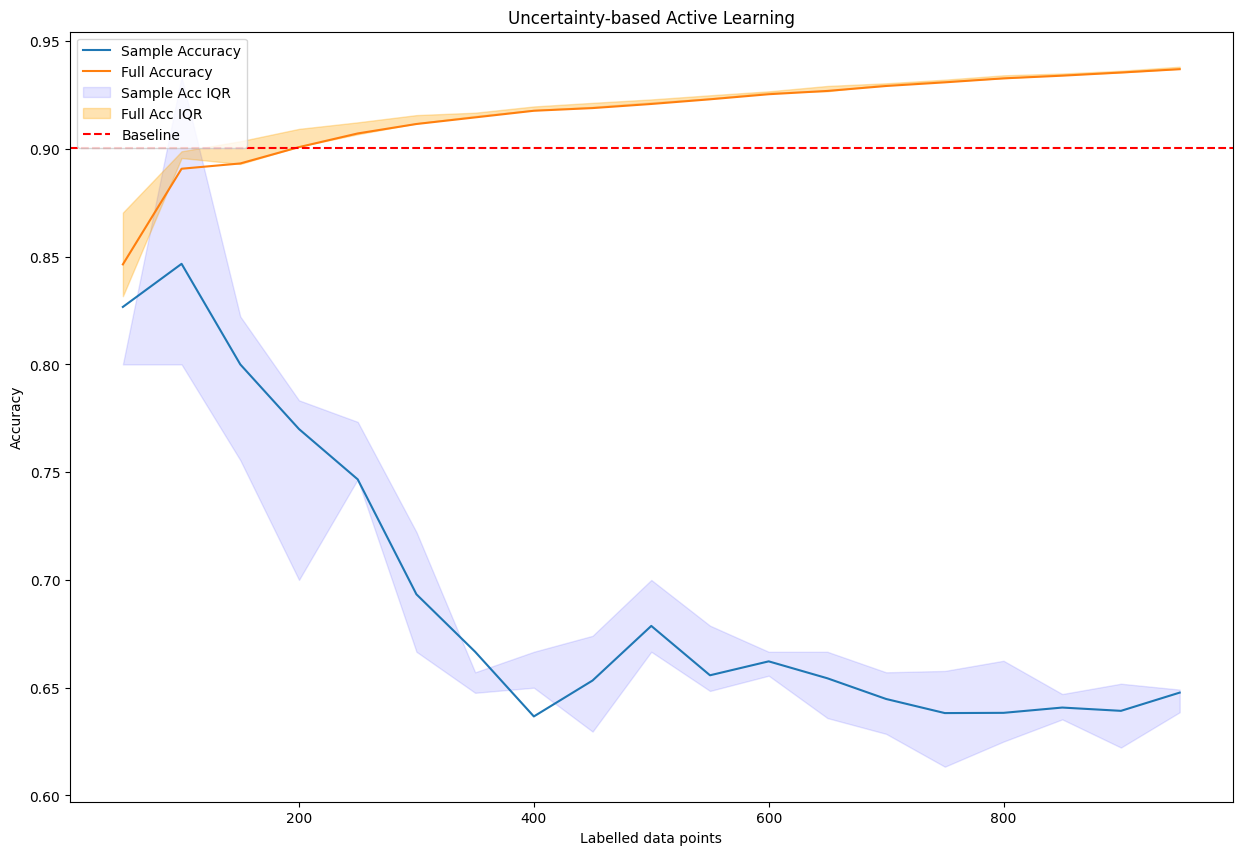

In [37]:
accuracies_uncertainty_df, stats_sample_uncertainty_df, stats_full_uncertainty_df = process_accuracy(tot_accuracies_uncertainty)
plot_result(accuracies_uncertainty_df, stats_sample_uncertainty_df, stats_full_uncertainty_df, baseline_accuracy, title='Uncertainty-based Active Learning', show_iqr_sample=True)

#### Optimization Results

In [38]:
layout_factor_uncertainty, objective_factor_uncertainty = process_opti_factors(tot_layout_factor_uncertainty, tot_objective_factor_uncertainty)

In [96]:
fig, ax = plt.subplots(1,4, figsize=(24,6), dpi=600)

layout_factor_duality.plot(x='Size', y='average', ax=ax[0], label='Optimization-aware')
ax[0].fill_between(layout_factor_duality['Size'], layout_factor_duality['first_qnt'], layout_factor_duality['third_qnt'], alpha=0.2)
layout_factor_uncertainty.plot(x='Size', y='average', ax=ax[0], label='Uncertainty-based')
ax[0].fill_between(layout_factor_uncertainty['Size'], layout_factor_uncertainty['first_qnt'], layout_factor_uncertainty['third_qnt'], alpha=0.2)
layout_factor_random.plot(x='Size', y='average', ax=ax[0], label='Random')
ax[0].fill_between(layout_factor_random['Size'], layout_factor_random['first_qnt'], layout_factor_random['third_qnt'], alpha=0.2)
ax[0].set_ylim([0.05,0.2])
ax[0].set_title('Layout factor as a function of sample size')
ax[0].set_xlabel('Labelled data points', fontsize=15)
ax[0].grid(True, alpha=0.4)

objective_factor_duality.plot(x='Size', y='average', ax=ax[1], label='Optimization-aware')
ax[1].fill_between(objective_factor_duality['Size'], objective_factor_duality['first_qnt'], objective_factor_duality['third_qnt'], alpha=0.2)
objective_factor_uncertainty.plot(x='Size', y='average', ax=ax[1], label='Uncertainty-based')
ax[1].fill_between(objective_factor_uncertainty['Size'], objective_factor_uncertainty['first_qnt'], objective_factor_uncertainty['third_qnt'], alpha=0.2)
objective_factor_random.plot(x='Size', y='average', ax=ax[1], label='Random')
ax[1].fill_between(objective_factor_random['Size'], objective_factor_random['first_qnt'], objective_factor_random['third_qnt'], alpha=0.2)
ax[1].set_ylim([0,0.02])
ax[1].set_title('Objective factor as a function of sample size')
ax[1].set_xlabel('Labelled data points', fontsize=15)
ax[1].grid(True, alpha=0.4)

ax[2].plot(accuracies_df_duality.reset_index()['index'], accuracies_df_duality['Sample Accuracy'], label='Optimization-Aware')
ax[2].fill_between(accuracies_df_duality.reset_index()['index'], stats_sample_df_duality['25%'], stats_sample_df_duality['75%'], alpha=0.1)
ax[2].plot(accuracies_uncertainty_df.reset_index()['index'], accuracies_uncertainty_df['Sample Accuracy'], label='Uncertainty-based')
ax[2].fill_between(accuracies_uncertainty_df.reset_index()['index'], stats_sample_uncertainty_df['25%'], stats_sample_uncertainty_df['75%'], alpha=0.1)
ax[2].plot(accuracies_df_random.reset_index()['index'], accuracies_df_random['Sample Accuracy'], label='Random')
ax[2].fill_between(accuracies_df_random.reset_index()['index'], stats_sample_df_random['25%'], stats_sample_df_random['75%'], alpha=0.1)
ax[2].axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
ax[2].set_title('Validation classification accuracy \nas a function of sample size')
ax[2].set_ylim([0.60,1])
ax[2].grid(True, alpha=0.4)
ax[2].set_xlabel('Labelled data points', fontsize=15)
ax[2].legend()

ax[3].plot(accuracies_df_duality.reset_index()['index'], accuracies_df_duality['Full Accuracy'], label='Optimization-Aware')
ax[3].fill_between(accuracies_df_duality.reset_index()['index'], stats_full_df_duality['25%'], stats_full_df_duality['75%'], alpha=0.1)
ax[3].plot(accuracies_uncertainty_df.reset_index()['index'], accuracies_uncertainty_df['Full Accuracy'], label='Uncertainty-based')
ax[3].fill_between(accuracies_uncertainty_df.reset_index()['index'], stats_full_uncertainty_df['25%'], stats_full_uncertainty_df['75%'], alpha=0.1)
ax[3].plot(accuracies_df_random.reset_index()['index'], accuracies_df_random['Full Accuracy'], label='Random')
ax[3].fill_between(accuracies_df_random.reset_index()['index'], stats_full_df_random['25%'], stats_full_df_random['75%'], alpha=0.1)
ax[3].set_title('Out-of-sample classification accuracy \nas a function of sample size')
ax[3].axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
ax[3].set_ylim([0.60,1])
ax[3].set_xlabel('Labelled data points', fontsize=15)
ax[3].grid(True, alpha=0.4)
ax[3].legend()

plt.legend()
plt.tight_layout()
plt.savefig('saved_images/comprehensive_plot.png')
plt.show()

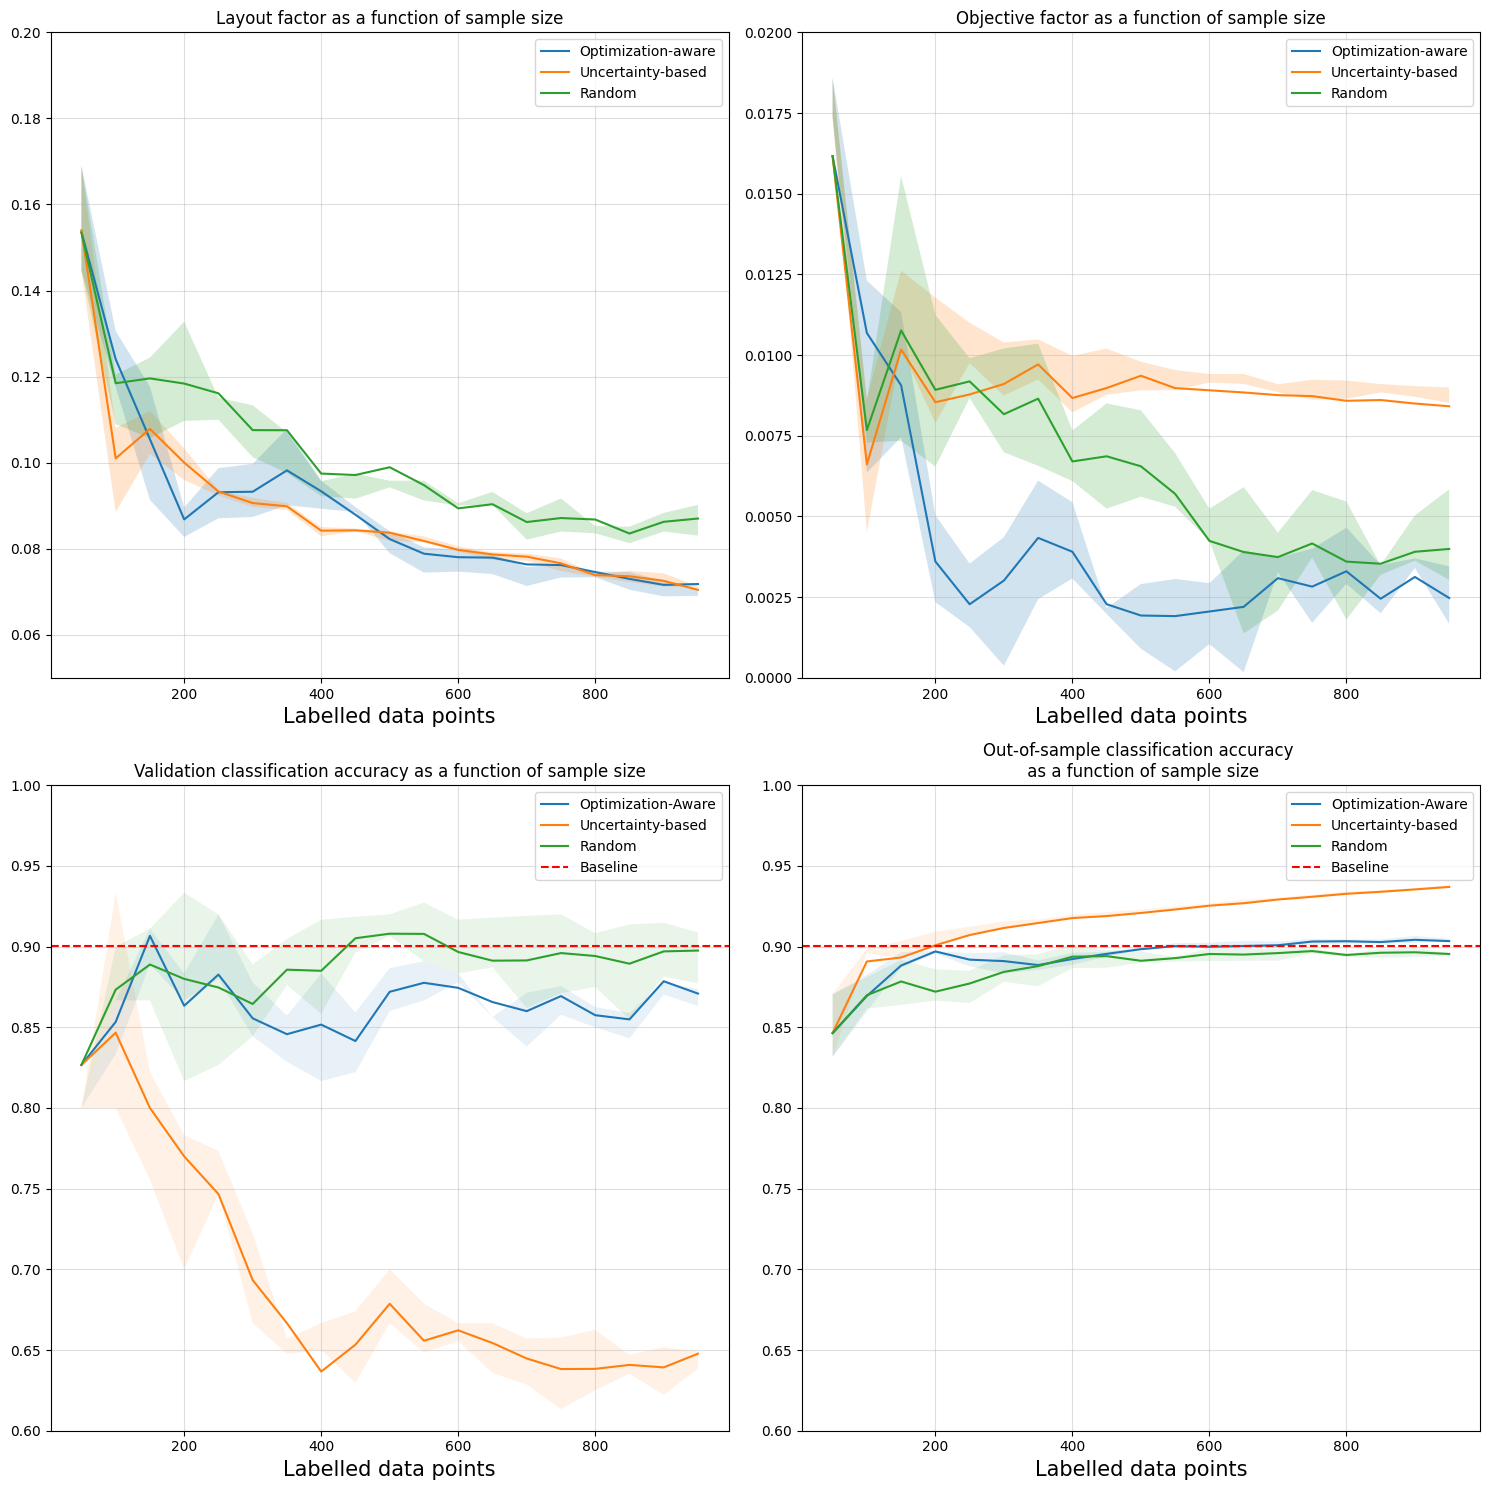

In [93]:
fig, ax = plt.subplots(2,2, figsize=(15,15))

layout_factor_duality.plot(x='Size', y='average', ax=ax[0][0], label='Optimization-aware')
ax[0][0].fill_between(layout_factor_duality['Size'], layout_factor_duality['first_qnt'], layout_factor_duality['third_qnt'], alpha=0.2)
layout_factor_uncertainty.plot(x='Size', y='average', ax=ax[0][0], label='Uncertainty-based')
ax[0][0].fill_between(layout_factor_uncertainty['Size'], layout_factor_uncertainty['first_qnt'], layout_factor_uncertainty['third_qnt'], alpha=0.2)
layout_factor_random.plot(x='Size', y='average', ax=ax[0][0], label='Random')
ax[0][0].fill_between(layout_factor_random['Size'], layout_factor_random['first_qnt'], layout_factor_random['third_qnt'], alpha=0.2)
ax[0][0].set_ylim([0.05,0.2])
ax[0][0].set_title('Layout factor as a function of sample size')
ax[0][0].set_xlabel('Labelled data points', fontsize=15)
ax[0][0].grid(True, alpha=0.4)

objective_factor_duality.plot(x='Size', y='average', ax=ax[0][1], label='Optimization-aware')
ax[0][1].fill_between(objective_factor_duality['Size'], objective_factor_duality['first_qnt'], objective_factor_duality['third_qnt'], alpha=0.2)
objective_factor_uncertainty.plot(x='Size', y='average', ax=ax[0][1], label='Uncertainty-based')
ax[0][1].fill_between(objective_factor_uncertainty['Size'], objective_factor_uncertainty['first_qnt'], objective_factor_uncertainty['third_qnt'], alpha=0.2)
objective_factor_random.plot(x='Size', y='average', ax=ax[0][1], label='Random')
ax[0][1].fill_between(objective_factor_random['Size'], objective_factor_random['first_qnt'], objective_factor_random['third_qnt'], alpha=0.2)
ax[0][1].set_ylim([0,0.02])
ax[0][1].set_title('Objective factor as a function of sample size')
ax[0][1].set_xlabel('Labelled data points', fontsize=15)
ax[0][1].grid(True, alpha=0.4)

ax[1][0].plot(accuracies_df_duality.reset_index()['index'], accuracies_df_duality['Sample Accuracy'], label='Optimization-Aware')
ax[1][0].fill_between(accuracies_df_duality.reset_index()['index'], stats_sample_df_duality['25%'], stats_sample_df_duality['75%'], alpha=0.1)
ax[1][0].plot(accuracies_uncertainty_df.reset_index()['index'], accuracies_uncertainty_df['Sample Accuracy'], label='Uncertainty-based')
ax[1][0].fill_between(accuracies_uncertainty_df.reset_index()['index'], stats_sample_uncertainty_df['25%'], stats_sample_uncertainty_df['75%'], alpha=0.1)
ax[1][0].plot(accuracies_df_random.reset_index()['index'], accuracies_df_random['Sample Accuracy'], label='Random')
ax[1][0].fill_between(accuracies_df_random.reset_index()['index'], stats_sample_df_random['25%'], stats_sample_df_random['75%'], alpha=0.1)
ax[1][0].axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
ax[1][0].set_title('Validation classification accuracy as a function of sample size')
ax[1][0].set_ylim([0.60,1])
ax[1][0].grid(True, alpha=0.4)
ax[1][0].set_xlabel('Labelled data points', fontsize=15)
ax[1][0].legend()

ax[1][1].plot(accuracies_df_duality.reset_index()['index'], accuracies_df_duality['Full Accuracy'], label='Optimization-Aware')
ax[1][1].fill_between(accuracies_df_duality.reset_index()['index'], stats_full_df_duality['25%'], stats_full_df_duality['75%'], alpha=0.1)
ax[1][1].plot(accuracies_uncertainty_df.reset_index()['index'], accuracies_uncertainty_df['Full Accuracy'], label='Uncertainty-based')
ax[1][1].fill_between(accuracies_uncertainty_df.reset_index()['index'], stats_full_uncertainty_df['25%'], stats_full_uncertainty_df['75%'], alpha=0.1)
ax[1][1].plot(accuracies_df_random.reset_index()['index'], accuracies_df_random['Full Accuracy'], label='Random')
ax[1][1].fill_between(accuracies_df_random.reset_index()['index'], stats_full_df_random['25%'], stats_full_df_random['75%'], alpha=0.1)
ax[1][1].set_title('Out-of-sample classification accuracy \n as a function of sample size')
ax[1][1].axhline(y=baseline_accuracy, color='r', linestyle='--', label='Baseline')
ax[1][1].set_ylim([0.60,1])
ax[1][1].set_xlabel('Labelled data points', fontsize=15)
ax[1][1].grid(True, alpha=0.4)
ax[1][1].legend()

plt.legend()
plt.tight_layout()
plt.show()

### **Distribution based**

In [42]:
tot_accuracies_distr = []
tot_objective_factor_distr = []
tot_layout_factor_distr = []

for seed in range(1, 6):
    print(f"{seed}")
    accuracies_u = {}
    objective_factors = {}
    layout_factors = {}

    non_labelled_df, current_sample = train_test_split(df, test_size=50, random_state=seed, stratify=df['Suitable'])
    step = 50
    
    for size in range(50, 1000, step):
        ### TRAIN CLASSIFICATION MODEL
        # Select labelled data and train model
        sample_acc, model, scaler = classificationModel(current_sample, seed=seed)
        # Predict on unlabelled data
        full_X_train_scaled = scaler.transform(non_labelled_df.drop('Suitable', axis=1))
        full_y_pred = model.predict(full_X_train_scaled)
        full_acc = accuracy_score(non_labelled_df['Suitable'], full_y_pred)
        # Store accuracies
        accuracies_u[size] = [sample_acc, full_acc]

        ### COMPUTE FULL PREDICTION / Z HAT VECTOR
        full_X_scaled = scaler.transform(df.drop('Suitable', axis=1))
        z_hat = pd.DataFrame(model.predict(full_X_scaled))
        z_hat.columns = ['z_hat']
        z_hat_df = pd.merge(z_hat, current_sample[['Suitable']], left_index=True, right_index=True, how='left')
        z_hat_df.columns = ['z_hat', 'Suitable']
        z_hat_df['z_hat_adjusted'] = np.where(z_hat_df['Suitable'].isnull(), z_hat_df['z_hat'], z_hat_df['Suitable'])
        
        ### RUN OPTI MODEL
        opt_objective, df_X, df_Y, dual_df = solve_opti_model(z_hat_df['z_hat_adjusted'].to_numpy(), supply, tr_capacity, des_capacity, cost_1, cost_2, df)

        ### STORE OPTI KPIs
        if opt_objective > 0: # feasible
            # Compute objective factor
            objective_factor = np.abs(1 - full_info_objective / opt_objective)
            # Compute layout factor
            comparison = pd.merge(df_Y_optimal, df_Y, on =['j','k'], how='inner')
            comparison['Difference'] = np.abs(comparison['Value_x'] - comparison['Value_y']) / 2
            layout_factor = comparison['Difference'].sum() / supply.sum()
            objective_factors[size] = objective_factor
            layout_factors[size] = layout_factor

        ### UPDATE SAMPLE
        # Dissimilarity based selection
        current_sample, not_labelled_df = distribution_selection(current_sample, not_labelled_df, step)
            
    ### SAVE PERFORMANCES
    tot_accuracies_distr.append(accuracies_u)
    tot_objective_factor_distr.append(objective_factors)
    tot_layout_factor_distr.append(layout_factors)

1
Infeasible
Infeasible


ValueError: operands could not be broadcast together with shapes (10001,) (10000,) 

In [ ]:
accuracies_distr_df, stats_sample_distr_df, stats_full_distr_df = process_accuracy(tot_accuracies_distr)
plot_result(accuracies_distr_df, stats_sample_distr_df, stats_full_distr_df, baseline_accuracy, 'Duality-Based Active Learning', show_iqr_sample=True)

In [ ]:
layout_factor_distr, objective_factor_distr = process_opti_factors(tot_layout_factor_distr, tot_objective_factor_distr)

**Layout Factor**

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12,8))

layout_factor_duality.plot(x='Size', y='average', ax=ax[0], label='Duality-based')
ax[0].fill_between(layout_factor_duality['Size'], layout_factor_duality['first_qnt'], layout_factor_duality['third_qnt'], alpha=0.3)
layout_factor_uncertainty.plot(x='Size', y='average', ax=ax[0], label='Uncertainty-based')
ax[0].fill_between(layout_factor_uncertainty['Size'], layout_factor_uncertainty['first_qnt'], layout_factor_uncertainty['third_qnt'], alpha=0.3)
layout_factor_random.plot(x='Size', y='average', ax=ax[0], label='Random')
ax[0].fill_between(layout_factor_random['Size'], layout_factor_random['first_qnt'], layout_factor_random['third_qnt'], alpha=0.3)
layout_factor_distr.plot(x='Size', y='average', ax=ax[0], label='Distribution-based')
ax[0].fill_between(layout_factor_distr['Size'], layout_factor_distr['first_qnt'], layout_factor_distr['third_qnt'], alpha=0.3)
ax[0].set_ylim([0.05,0.2])
ax[0].set_title('Layout factor as a function of sample size')
ax[0].grid(True, alpha=0.4)

objective_factor_duality.plot(x='Size', y='average', ax=ax[1], label='Duality-based')
ax[1].fill_between(objective_factor_duality['Size'], objective_factor_duality['first_qnt'], objective_factor_duality['third_qnt'], alpha=0.3)
objective_factor_uncertainty.plot(x='Size', y='average', ax=ax[1], label='Uncertainty-based')
ax[1].fill_between(objective_factor_uncertainty['Size'], objective_factor_uncertainty['first_qnt'], objective_factor_uncertainty['third_qnt'], alpha=0.3)
objective_factor_random.plot(x='Size', y='average', ax=ax[1], label='Random')
ax[1].fill_between(objective_factor_random['Size'], objective_factor_random['first_qnt'], objective_factor_random['third_qnt'], alpha=0.3)
objective_factor_distr.plot(x='Size', y='average', ax=ax[1], label='Distribution-based')
ax[1].fill_between(objective_factor_distr['Size'], objective_factor_distr['first_qnt'], objective_factor_distr['third_qnt'], alpha=0.3)
ax[1].set_ylim([0,0.02])
ax[1].set_title('Objective factor as a function of sample size')
ax[1].grid(True, alpha=0.4)

plt.legend()
plt.show()